In [223]:
import sys

import pandas 
import scipy
import numpy

import matplotlib.pyplot
import seaborn

import random

sys.path.append("../scripts")
import utils

In [178]:
def parse_results(results_file):
    # load scores
    results = {}

    with open(results_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            results[ENSG] = float(score)

    return results

In [179]:
def parse_leave_one_out(results_file):
    # load left-out scores
    results_left_out = {}

    with open(results_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            results_left_out[ENSG] = float(score)
        
    return results_left_out

In [180]:
def check_pvalue(pvalue):
    # if pvalue < 0.0001:
    #     return "p-value < 0.0001"
    # if pvalue < 0.001:
    #     return "p-value < 0.001"
    # if pvalue < 0.01:
    #     return "p-value < 0.01"
    # if pvalue < 0.05:
    #     return "p-value < 0.05"
    # else:
    #     return "p-value >= 0.05"

    return '{:.2e}'.format(pvalue)

In [181]:
def compare_scores(results, results_left_out):
    results = results.copy()
    for left_out in results_left_out:
        del results[left_out]

    df_results = pandas.DataFrame.from_dict(results, 
                                       orient='index', 
                                       columns=['score'])
    df_results['group'] = "non-causal"

    df_results_left_out = pandas.DataFrame.from_dict(results_left_out, 
                                                    orient='index', 
                                                    columns=['score'])

    df_results_left_out['group'] = 'left-out'

    # concatenate dataframes for comparison
    df_compare = pandas.concat([df_results, df_results_left_out])

    stat, pvalue = scipy.stats.ranksums(df_results['score'].values, df_results_left_out['score'].values, alternative='less')

    pvalue_thresh = check_pvalue(pvalue)

    print(stat, pvalue)

    return df_compare, pvalue_thresh

In [182]:
def causal_genes_at_distance(dict_distances, node, d):
    try:
        return len([dist for dist in dict_distances.get(node).values() if dist == d])
    except:
        return 0

In [183]:
def geneName_to_ENSG(genes_file):
    genes = {}

    f = open(genes_file, 'r')
    
    # skip header
    next(f)

    for line in f:
        line_splitted = line.rstrip().split('\t')
        gene_name, ENSG = line_splitted

        genes[gene_name] = ENSG
    
    return genes

#### Set parameters

In [1061]:
PHENOTYPE = "CARDIOM"
ALPHA = 0.5
D_MAX = 10
ALPHA_NORM = 10

NEW_CENTRALITY_VERSION = "v8"


#### Load the necessary data

In [1062]:
interactome = utils.parse_interactome(interactome_file="/home/kubicaj/calc/input/Interactome_human.sif")

alpha = str(ALPHA).replace('.', '')
results = parse_results(f"/home/kubicaj/calc/output/New_centrality_{NEW_CENTRALITY_VERSION}/{PHENOTYPE}/alpha{alpha}_dmax{D_MAX}_alphanorm_{ALPHA_NORM}/scores.tsv")
results_leave_one_out = parse_leave_one_out(f"/home/kubicaj/calc/output/New_centrality_{NEW_CENTRALITY_VERSION}/{PHENOTYPE}/alpha{alpha}_dmax{D_MAX}_alphanorm_{ALPHA_NORM}/scores_leave_one_out.tsv")

#### Analyze leave-one-out results: newCentrality.py

In [1063]:
df_compare, p_value = compare_scores(results, results_leave_one_out)

-2.363577686208497 0.009049715746043758


Text(0.5, 1.0, 'Compare non-causal genes scores (all MMAF genes used)\n with scores for MMAF genes (leave-one-out)\nalpha=0.01,   d=10,    alpha_norm=1')

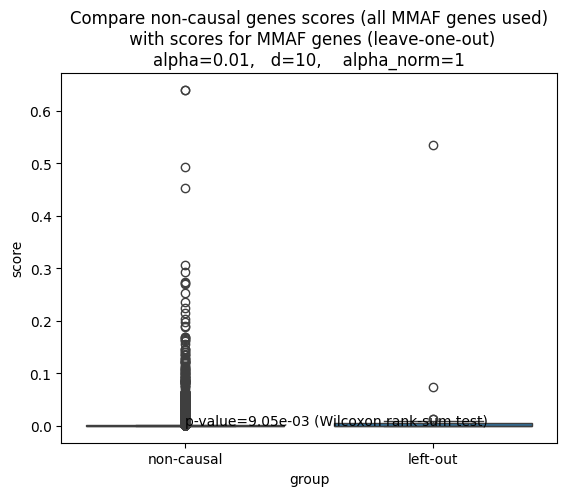

In [1064]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Compare non-causal genes scores (all {PHENOTYPE} genes used)\n with scores for {PHENOTYPE} genes (leave-one-out)\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}")
# matplotlib.pyplot.ylim(0,2)

In [1065]:
# top 10 high-scoring genes
results_sorted = sorted(results.keys(), key=lambda item: results[item], reverse=True)
results_sorted[:10]

['ENSG00000165556',
 'ENSG00000187753',
 'ENSG00000137473',
 'ENSG00000066557',
 'ENSG00000180376',
 'ENSG00000205922',
 'ENSG00000141933',
 'ENSG00000146842',
 'ENSG00000025708',
 'ENSG00000176225']

In [1066]:
scores_sorted = [results[node] for node in results_sorted]
scores_sorted[:10]

[0.6400775562695726,
 0.6400775562695726,
 0.5346011739866728,
 0.49398396974829645,
 0.4540951142860845,
 0.30732562736988667,
 0.29291419730836715,
 0.2743934095592952,
 0.272190620814508,
 0.27023856888815595]

In [1067]:
len(results), len(results_sorted)

(14393, 14393)

#### Analyze new candidates from 13/02/2024

In [1068]:
genes = geneName_to_ENSG("/home/kubicaj/calc/input/canonicalGenes.tsv")

In [1069]:
new_candidates_names = ['CLHC1', 'PHF20', 'NUSAP1', 'CDC20B', 'FAM221A', 'GALR3', 'LRRC9', 'KIF27', 'ZNF208', 'C6orf118', 'CCDC66', 'CCNA1', 'DDX43', 'FSCB', 'FHAD1', 'LRGUK', 'MYCBPAP', 'MYH7B', 'PCDHB15', 'SAMD15', 'SPACA9', 'SPATA24', 'SPATA6', 'TSSK4', 'TTLL2']
new_candidates_ENSG = [genes.get(n) for n in new_candidates_names]
new_candidates = [n for n in new_candidates_ENSG if n in interactome]

In [1070]:
# check scores of new candidates
scores_new_candidates = {n: results.get(n) for n in new_candidates}

In [1071]:
scores_new_candidates

{'ENSG00000162994': 0.0009256413628031906,
 'ENSG00000025293': 0.00019650250971985021,
 'ENSG00000164287': 0.003216222886868855,
 'ENSG00000188732': 0.002704951740198899,
 'ENSG00000128310': 9.22702837473831e-06,
 'ENSG00000165115': 0.0026635508162862623,
 'ENSG00000180376': 0.4540951142860845,
 'ENSG00000133101': 0.0013813585575950201,
 'ENSG00000080007': 0.0,
 'ENSG00000142621': 0.006234573195298203,
 'ENSG00000136449': 0.00016510470177517208,
 'ENSG00000078814': 0.00031053383555590896,
 'ENSG00000165698': 0.0002784552738662868,
 'ENSG00000170469': 0.0013389303922067785,
 'ENSG00000132122': 0.0007783473663144224,
 'ENSG00000139908': 0.00021018363653337992,
 'ENSG00000120440': 2.3139446963129176e-06}

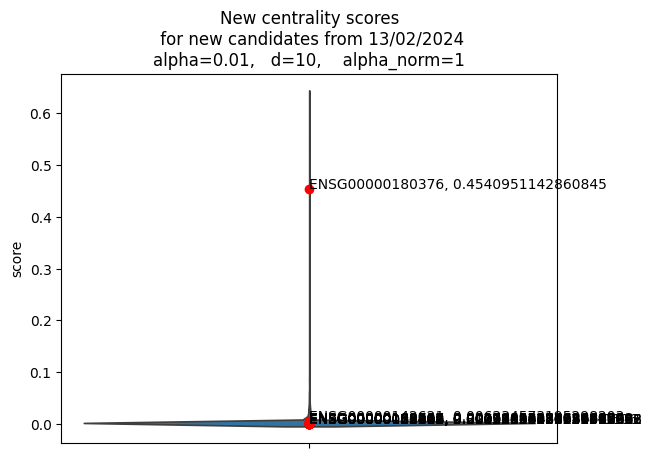

In [1072]:
seaborn.violinplot(data=df_compare, y='score')
matplotlib.pyplot.title(f"New centrality scores\n for new candidates from 13/02/2024\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}")

for canidate, score in scores_new_candidates.items():
    matplotlib.pyplot.plot(score, 'or')
    matplotlib.pyplot.text(0, score, s=f"{canidate}, {score}")

### Compare New centrality with other centralities (degree, betweenness)

In [1073]:
CENTRALITY = "degree"

In [1074]:
results_sorted = list(results.keys())
scores_sorted = [results[node] for node in results_sorted]

scores_leave_one_out_sorted = [results[node] for node in results_leave_one_out]

In [1075]:
results_centrality = parse_results(f"/home/kubicaj/calc/output/{CENTRALITY}_centrality/{PHENOTYPE}/scores.tsv")
for node in results_centrality:
    if node not in results:
        del results_centrality[node]

scores_centrality_sorted = [results_centrality[node] for node in results_sorted]

In [1076]:
scores_centrality_causal_sorted = [results_centrality[node] for node in results_leave_one_out]

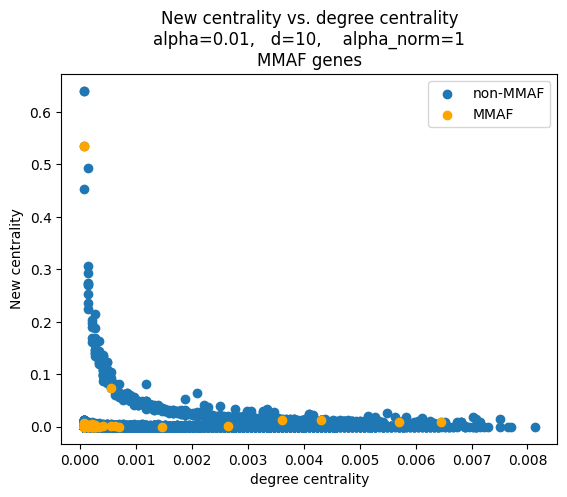

In [1077]:
matplotlib.pyplot.scatter(x=scores_centrality_sorted, y=scores_sorted, label=f"non-{PHENOTYPE}")
matplotlib.pyplot.scatter(x=scores_centrality_causal_sorted, y=scores_leave_one_out_sorted, c='orange', label=f"{PHENOTYPE}")

matplotlib.pyplot.title(f"New centrality vs. {CENTRALITY} centrality\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}\n{PHENOTYPE} genes")
matplotlib.pyplot.ylabel("New centrality")
matplotlib.pyplot.xlabel(f"{CENTRALITY} centrality")
matplotlib.pyplot.legend()

#### Random sampling New centrality vs. other centralities

In [1078]:
random.seed(1)

random_sample_size = len(results_leave_one_out)
random_sample = random.sample(list(results.keys()), random_sample_size)

scores_random_sample = [results[node] for node in random_sample]
scores_centrality_random_sample = [results_centrality[node] for node in random_sample]

In [1079]:
# DC_random + NC_random
x = scores_centrality_random_sample + scores_random_sample
# DC_MMAF + NC_MMAF
y = scores_centrality_causal_sorted + scores_leave_one_out_sorted

stats, p_value = scipy.stats.pearsonr(x, y)
R2 = '{:g}'.format(float('{:.1g}'.format(stats**2)))
p_value = check_pvalue(pvalue=p_value)

Text(6.948304613674263e-05, 8.082948668936384e-06, 'R^2 = 0.1\np-value = 3.83e-02 (Pearson)')

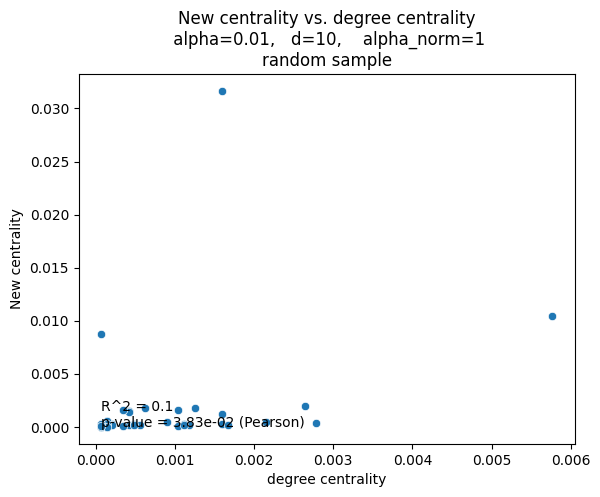

In [1080]:
x = scores_centrality_random_sample
y = scores_random_sample

stats, p_value = scipy.stats.pearsonr(x, y)
R2 = '{:g}'.format(float('{:.1g}'.format(stats**2)))
p_value = check_pvalue(pvalue=p_value)

seaborn.scatterplot(x=x,
                y=y)

matplotlib.pyplot.title(f"New centrality vs. {CENTRALITY} centrality\n alpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}\nrandom sample")
matplotlib.pyplot.ylabel("New centrality")
matplotlib.pyplot.xlabel(f"{CENTRALITY} centrality")
matplotlib.pyplot.text(x=min(x), y=min(y), s=f"R^2 = {R2}\np-value = {p_value} (Pearson)")

Text(6.948304613674263e-05, 6.98677055756862e-08, 'R^2 = 0.002\np-value = 7.73e-01 (Pearson)')

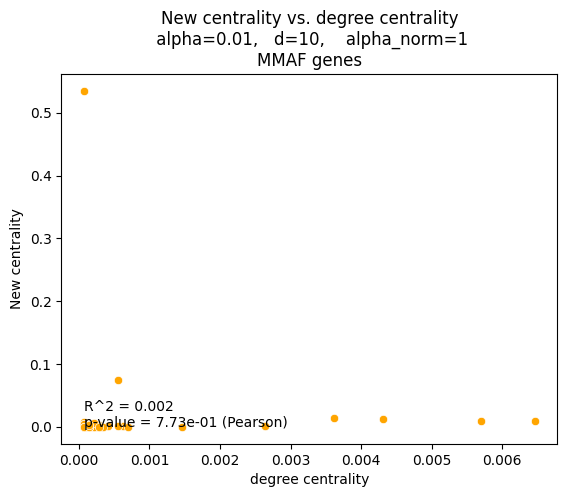

In [1081]:
x = scores_centrality_causal_sorted
y = scores_leave_one_out_sorted

stats, p_value = scipy.stats.pearsonr(x, y)
R2 = '{:g}'.format(float('{:.1g}'.format(stats**2)))
p_value = check_pvalue(pvalue=p_value)

seaborn.scatterplot(x=x,
                y=y,
                color='orange')

matplotlib.pyplot.title(f"New centrality vs. {CENTRALITY} centrality\n alpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}\n{PHENOTYPE} genes")
matplotlib.pyplot.ylabel("New centrality")
matplotlib.pyplot.xlabel(f"{CENTRALITY} centrality")
matplotlib.pyplot.text(x=min(x), y=min(y), s=f"R^2 = {R2}\np-value = {p_value} (Pearson)")

#### GTEx tissue-enrichment - Are tissue-specific genes significantly enriched in the predicted causal genes?

In [1112]:
def intersection(list_1, list_2):
    return list(set(list_1) & set(list_2))

In [1113]:
def take_top(list, percent):
    num_elements = int(len(list) * percent/100)
    num_elements = max(num_elements, 1)
    
    return list[:num_elements], list[num_elements:]

In [1114]:
results_sorted = sorted(results.keys(), key=lambda item: results[item], reverse=True)

scores_sorted = [results[node] for node in results_sorted]

In [1134]:
PRED_CAUSAL_DEFINITION = 10 # [%]
TISSUE_DEFINITION = 10 # [%]

TISSUE = "testis"

In [1135]:
# get top 10 genes from New centrality
pred_causal, non_pred_causal = take_top(results_sorted, PRED_CAUSAL_DEFINITION)

In [1136]:
# load tissue expression from grexome-TIMC-Secondary-interactome/GTEX_Data
GTEx_tissue = {}

with open(f"/home/kubicaj/calc/grexome-TIMC-Secondary-interactome/GTEX_Data/E-MTAB-5214-query-results-{TISSUE}-ratio.tpms.tsv") as f:
    # skip header
    for _ in range(5):
        next(f)
    for line in f:
        split_line = line.rstrip().split('\t')
        if len(split_line) != 3:
            continue
        ENSG, tissue_abundance, tissue_ratio = split_line
        if tissue_abundance == '':
            continue
        if ENSG in interactome.nodes():
            GTEx_tissue[ENSG] = float(tissue_ratio)

In [1137]:
# # get top 10% of genes expressed in the tissue
GTEx_tissue_sorted = sorted(GTEx_tissue.keys(), key=lambda item: GTEx_tissue[item], reverse=True)
tissue_enriched, non_tissue_enriched = take_top(GTEx_tissue_sorted, TISSUE_DEFINITION)

In [1138]:
# construct a contingency matrix for Fisher's test
x1 = len(intersection(pred_causal, tissue_enriched))
x2 = len(intersection(non_pred_causal, tissue_enriched))
x3 = len(intersection(pred_causal, non_tissue_enriched))
x4 = len(intersection(non_pred_causal, non_tissue_enriched))

contingency_matrix = [[x1, x2], [x3, x4]]
contingency_matrix

[[126, 1302], [1304, 11552]]

In [1139]:
# The one-sided p-value for alternative='greater' is the probability that a random table has x >= a
# Then: The one-sided p-value for alternative='less' is the probability that a random table has x < a
# where contingency_matrix = [[a, b], [c, d]]
stats, pvalue = scipy.stats.fisher_exact(contingency_matrix, alternative='greater')
check_pvalue(pvalue=pvalue)

'9.49e-01'

Text(0.5, 1.0, 'Contingency table\n              alpha=0.01,   d=10,    alpha_norm=1\n              p-value = 9.49e-01\n              PRED_MMAF_DEFINITION: Top 10%\n              testis_DEFINITION: Top 10%\n              ')

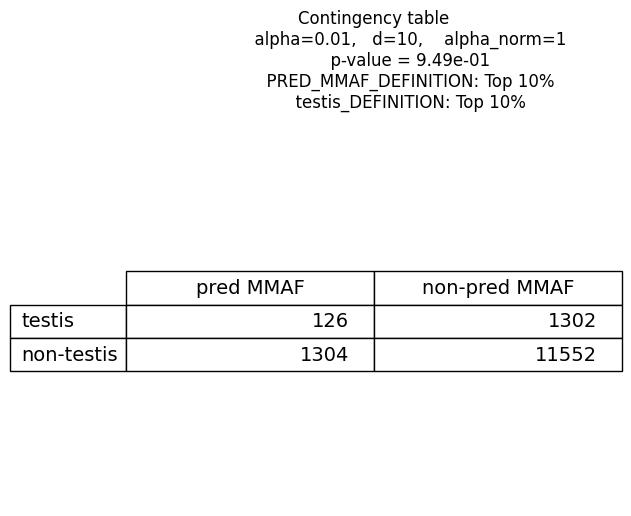

In [1142]:
fig, ax = matplotlib.pyplot.subplots(1,1)
table = ax.table(contingency_matrix, rowLabels=[f'{TISSUE}', f'non-{TISSUE}'], colLabels=[f'pred {PHENOTYPE}', f'non-pred {PHENOTYPE}'], loc="center")
ax.axis('tight')
ax.axis('off')
table.set_fontsize(14)
table.scale(1,2)

ax.set_title(f'''Contingency table
              alpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}
              p-value = {check_pvalue(pvalue=pvalue)}
              PRED_{PHENOTYPE}_DEFINITION: Top {PRED_CAUSAL_DEFINITION}%
              {TISSUE}_DEFINITION: Top {TISSUE_DEFINITION}%
              ''')

Text(0.5, 1.0, '11552')

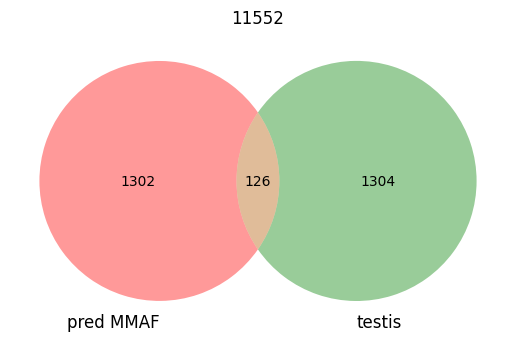

In [1143]:
from matplotlib_venn import venn2

venn2(subsets = (x2, x3, x1), set_labels = (f'pred {PHENOTYPE}', f'{TISSUE}'))
matplotlib.pyplot.title(x4)

#### Human Phenotype Ontology - muscle

In [1093]:
(ENSG2gene, gene2ENSG) = utils.parse_gene2ENSG(gene2ENSG_file="/home/kubicaj/calc/input/canonicalGenes.tsv")

In [1094]:
HPO_associated = []

HP = "HP_0012864" # "Abnormal sperm morphology"
HP = "HP_0003251" # "Male infertility"

with open(f"/home/kubicaj/calc/input/genes_for_{HP}.tsv") as f:
    # skip header
    next(f)
    for line in f:
        split_line = line.rstrip().split('\t')
        entrez_id, gene_name, _ = split_line
        if gene_name in gene2ENSG:
            ENSG = gene2ENSG[gene_name]
        if ENSG in interactome.nodes():
            HPO_associated.append(ENSG)

print(len(HPO_associated))

166


In [1095]:
non_HPO_associated = []

for node in interactome.nodes():
    if node not in HPO_associated:
        non_HPO_associated.append(node)

In [1096]:
# get top 10 genes from New centrality
pred_MMAF_idx = int(len(results_sorted) / 10)
pred_MMAF = results_sorted[:pred_MMAF_idx]

non_pred_MMAF = results_sorted[pred_MMAF_idx:]

In [1097]:
# construct a contingency matrix for Fisher's test
x1 = len(intersection(pred_MMAF, HPO_associated))
x2 = len(intersection(pred_MMAF, non_HPO_associated))
x3 = len(intersection(non_pred_MMAF, HPO_associated))
x4 = len(intersection(non_pred_MMAF, non_HPO_associated))

contingency_matrix = [[x1, x2], [x3, x4]]
contingency_matrix

[[27, 1412], [126, 12828]]

In [1098]:
# The one-sided p-value for alternative='greater' is the probability that a random table has x >= a
# Then: The one-sided p-value for alternative='less' is the probability that a random table has x < a
# where contingency_matrix = [[a, b], [c, d]]
stats, pvalue = scipy.stats.fisher_exact(contingency_matrix, alternative='greater')
check_pvalue(pvalue=pvalue)

'2.44e-03'